In [71]:
#Will want nice pictures illustrating natural cutoff points for choosing how many PCs
#For Permutation 12,19 are natural choices.  But 10 isnt as natural/obvious
#While for PCQC it is a more obvious choice.  Its also computationally much faster

In [1]:
import sys
sys.path.append('../pcqc')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pcqc import *
import scanpy as sc
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, log_loss, confusion_matrix
from sklearn.metrics import average_precision_score, recall_score

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
from matplotlib.backends.backend_pdf import PdfPages
plot_dictionary = dict()

In [49]:
output_plots = 'pbmc_plots/cluster_plots.pdf'

In [3]:
adata = sc.read(filename = 'pbmc_sample_preprocess.h5ad')

In [18]:
ground_truth = pd.read_csv('sample_reweighted_ground_truth.csv')

In [19]:
ground_truth.head()

,Unnamed: 0,truth_names
0,1149,CD8
1,67,CD4 T
2,1448,Other
3,1147,CD4 T
4,1107,Other


In [20]:
ground_truth.head()

,Unnamed: 0,truth_names
0,1149,CD8
1,67,CD4 T
2,1448,Other
3,1147,CD4 T
4,1107,Other


In [21]:
ground_truth = ground_truth[['truth_names']]

In [23]:
ground_truth.columns = ['leiden']

In [24]:
ground_truth['count'] = 1

In [25]:
df = pd.DataFrame(adata.X)

In [26]:
df

,0,1,2,3,4,5,6,7,8,9,...,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837
0,-0.259981,3.922045,-0.054651,-0.438394,-0.547078,-0.261272,-0.060680,-0.232851,1.977761,-0.191627,...,2.990248,3.270376,-0.129937,-0.207859,-0.373641,-0.092098,-0.494547,-0.122425,-0.193726,1.296721
1,3.438393,-0.430909,-0.095609,-0.415347,1.435919,-0.264853,-0.022208,-0.238998,-0.408162,4.016506,...,-0.179171,-0.225732,-0.112785,-0.244154,-0.473587,-0.118382,-0.443634,-0.104933,-0.214405,-0.472855
2,-0.199613,-0.248815,-0.048544,-0.520762,-0.507041,-0.244888,-0.051908,-0.269483,-0.344053,-0.244253,...,-0.226354,-0.186549,-0.059374,4.148563,-0.285256,-0.141428,-0.478542,-0.059483,-0.172740,-0.446731
3,-0.231031,-0.264484,-0.047949,-0.487184,-0.519125,-0.251646,-0.058700,-0.253261,-0.365191,-0.217443,...,-0.236312,-0.220165,-0.091039,-0.230825,-0.315376,-0.118167,-0.489420,-0.087901,-0.180131,1.675896
4,-0.245581,-0.243716,-0.040638,-0.488954,-0.508401,3.718846,-0.065998,-0.251049,-0.364415,-0.206107,...,-0.247558,-0.228349,-0.096272,-0.222842,-0.299718,-0.111894,-0.499209,-0.092970,-0.176972,-0.504982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,-0.162950,-0.313787,-0.070139,-0.508488,-0.541426,5.061960,-0.031646,-0.272666,-0.350776,-0.272330,...,-0.195026,-0.169260,-0.050444,-0.272184,-0.338066,-0.155204,-0.451735,-0.050362,-0.183671,-0.413057
2324,-0.209894,-0.309613,-0.062325,-0.475366,1.725432,3.645148,-0.045882,-0.253645,-0.371959,-0.233335,...,-0.216435,-0.212219,-0.088472,-0.241171,-0.353927,-0.124878,-0.472664,-0.084857,-0.188235,-0.472760
2325,-0.190408,-0.261355,-0.053019,-0.520012,-0.513477,-0.244925,-0.047380,-0.270996,-0.344318,-0.251448,...,-0.219382,-0.181214,-0.055862,-0.258227,-0.294529,-0.145493,-0.472451,-0.056104,-0.174598,-0.437485
2326,-0.270597,-0.247519,-0.037987,-0.467578,-0.512972,-0.255837,-0.072692,-0.239772,-0.377976,-0.185094,...,-0.257540,-0.252830,-0.118566,3.700924,-0.314538,-0.094766,-0.509340,-0.113093,-0.180820,1.345477


### Define Functions

In [27]:
def data_sim(adata, sim_name, df_stats, ground_truth, res_params = np.arange(.4,2,.4), 
             n_neighbor_params = np.arange(10,30,5), trials = 20, random_state_start = 0, save = False,
            n_pcs = None, use_rep = None, save_directory = ''):
    random_state = random_state_start
    index = df_stats.shape[0]
    y = ground_truth['leiden']
    unique_values = np.unique(y)
    weights = ground_truth.groupby('leiden')['count'].transform(lambda x: 1/x.count()).values
    #create new directory to save results
    directory = save_directory + '/' + sim_name
    if save:
        os.mkdir(directory)
        
    for n_neighbors in n_neighbor_params:
        sc.pp.neighbors(adata,n_neighbors = n_neighbors, use_rep = use_rep, n_pcs = n_pcs)
        for res_param in res_params:
            for trial in range(trials):
                print('Trial: ' + str(np.round(trial,2)) + ' Res: ' + str(np.round(res_param,2)) + ' Nbrs: ' + str(np.round(n_neighbors,2)) + '   ', 
                      end = '\r')
                #compute simulation with metrics
                sc.tl.leiden(adata, resolution = res_param, random_state = random_state)
                X = pd.get_dummies(adata.obs['leiden'])
                predictions, metrics = compute_model_loss(X,y,weights)
                submetrics = compute_log_loss_by_class(predictions,y)
                new_row = [sim_name, trial, res_param, n_neighbors, 
                                       metrics['log_loss'], metrics['average_precision_score'],
                                      metrics['weighted_accuracy']] + submetrics
                
                df_stats.loc[index] = new_row
                
                #if we want to save the predictions
                if save:
                    file_location = directory + '/' + 'res_' + str(res_param) + 'n_nbrs_' + str(n_neighbors) \
                                + 'trial_' + str(trial) + '.npy'
                    np.save(file_location,predictions)
                    
                index += 1
                random_state += 1
    return df_stats

In [28]:
def compute_log_loss_by_class(predictions,y):
    output = []
    unique_values = np.unique(y)
    for response in unique_values:
        filtered_rows = np.where(y == response)[0]
        subset_log_loss = log_loss(y[filtered_rows], predictions[filtered_rows,:], labels = unique_values)
        output.append(subset_log_loss)
    return output

In [29]:
def compute_model_loss(X,y,weights):
    dummies_y = pd.get_dummies(y).values
    Bayes = MultinomialNB(fit_prior = False)
    Bayes.fit(X,y)
    predictions = Bayes.predict_proba(X)
    loglo = log_loss(y, predictions, sample_weight = weights)
    aps = average_precision_score(dummies_y, predictions, average = 'macro')
    weighted_accuracy = Bayes.score(X,y,sample_weight = weights)
    metrics = {'log_loss':loglo,'average_precision_score': aps,
               'weighted_accuracy':weighted_accuracy}
    return predictions, metrics

In [30]:
def prob_confusion_matrix(probs,ground_truth):
    #probabilistic confusion matrix that enforces balanced class sizes
    df = pd.DataFrame(probs)
    df['clusters'] = ground_truth
    confusion_matrix = df.groupby('clusters').mean()
    return confusion_matrix

### Experiment

In [31]:
adata = sc.AnnData(X = df.values)
sc.tl.pca(adata,n_comps = 100)

In [32]:
columns = ['name', 'trial', 'resolution', 'n_neighbors', 'log_loss','aps','weighted_accuracy']
for value in np.unique(ground_truth['leiden']):
    columns.append('log_loss_cluster_' + str(value))

df_stats = pd.DataFrame(columns = columns)

In [34]:
for n_pcs in [7, 25, 50, 100]:
    if n_pcs in [7]:
        string = 'PC_Scree_Perm' + str(n_pcs)
    else:
        string = 'PCs_' + str(n_pcs)
    df_stats = data_sim(adata, string, df_stats, ground_truth, random_state_start = 0, n_pcs = n_pcs)

In [36]:
pca = PC_Cluster(n_pcs = 100)
pca.fit(df.values)
pca.pc_distribution()
pca.pc_stats(thresholds=[0.9,0.95,0.98,0.99,0.995])
pca.select_top_pcs(criteria = '100.0_Percentile', n_top_pcs = 10)
reduced_matrix = pca.use_top_pcs()
adata_pcqc_kruskal = sc.AnnData(X = reduced_matrix)
df_stats = data_sim(adata_pcqc_kruskal, 'PCQC_99.5P_10PCs', df_stats, ground_truth, 
                    random_state_start = 0, n_pcs = 0, use_rep = 'X')

In [37]:
df_stats.groupby('name').median()

,resolution,log_loss,aps,weighted_accuracy,log_loss_cluster_B Cells,log_loss_cluster_CD14+,log_loss_cluster_CD4 T,log_loss_cluster_CD8,log_loss_cluster_Dendritic,log_loss_cluster_FCGR3A Monocytes,log_loss_cluster_Megakaryocytes,log_loss_cluster_NK,log_loss_cluster_Other
name,,,,,,,,,,,,,
PCQC_99.5P_10PCs,1.0,0.868936,0.606459,0.715590,0.566666,0.777130,1.341627,1.359085,1.112806,0.377740,0.294962,0.522533,1.490171
PC_Scree_Perm7,0.8,0.914851,0.584219,0.688174,0.580453,0.885544,1.344714,1.394332,1.276106,0.391039,0.294615,0.567228,1.508512
PCs_100,1.0,0.997160,0.511762,0.623948,0.629390,0.919661,1.436046,1.587295,1.311638,0.626837,0.328582,0.712135,1.552152
PCs_25,1.0,0.876855,0.600595,0.712350,0.590416,0.761794,1.321611,1.359742,1.168890,0.425696,0.292602,0.549856,1.471323
PCs_50,1.0,0.943175,0.535713,0.664537,0.618608,0.809464,1.350543,1.554260,1.206869,0.433518,0.310664,0.680336,1.498416


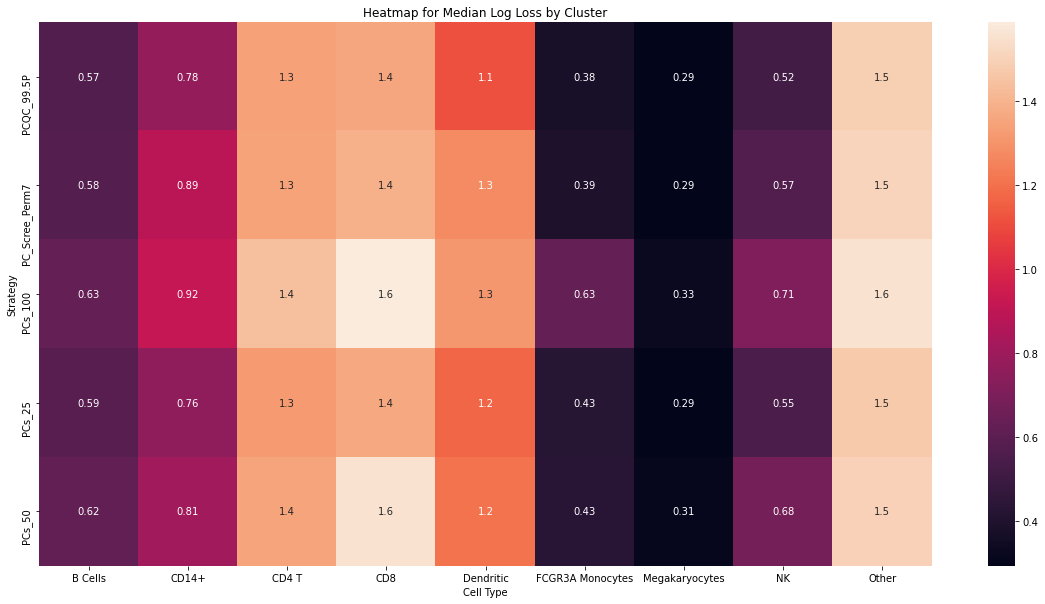

In [67]:
median_stats = df_stats.groupby('name').median()
reduced_names = [var.split('_')[-1] for var in median_stats.columns]
median_stats.columns = reduced_names
median_stats.rename(index = {'PCQC_99.5P_10PCs': 'PCQC_99.5P'}, inplace = True)
sns.heatmap(median_stats.iloc[:,-9:], annot = True)
plt.title('Heatmap for Median Log Loss by Cluster')
plt.ylabel('Strategy')
plt.xlabel('Cell Type')
plot_dictionary['ByClusterLoss'] = plt.gca().get_figure()

In [56]:
reduced_names[-9:]

['B Cells',
 'CD14+',
 'CD4 T',
 'CD8',
 'Dendritic',
 'FCGR3A Monocytes',
 'Megakaryocytes',
 'NK',
 'Other']

In [43]:
pd.options.display.max_columns = 200

In [44]:
df_stats.groupby('name').describe()

resolution                                               \
                      count      mean       std  min  25%  50%  75%  max   
name                                                                       
PCQC_99.5P_10PCs      320.0  1.000000  0.447914  0.4  0.7  1.0  1.3  1.6   
PC_Scree_Perm7        335.0  0.973134  0.455039  0.4  0.4  0.8  1.2  1.6   
PCs_100               320.0  1.000000  0.447914  0.4  0.7  1.0  1.3  1.6   
PCs_25                320.0  1.000000  0.447914  0.4  0.7  1.0  1.3  1.6   
PCs_50                320.0  1.000000  0.447914  0.4  0.7  1.0  1.3  1.6   

                 log_loss                                                    \
                    count      mean       std       min       25%       50%   
name                                                                          
PCQC_99.5P_10PCs    320.0  0.876992  0.037911  0.834726  0.862676  0.868936   
PC_Scree_Perm7      335.0  0.915976  0.010580  0.895283  0.909150  0.914851   
PCs_100             320.0  1.055823  0.146235  0.915731  0.943723  0.997160   
PCs_25              320.0  0.913353  0.075678  0.833863  0.866016  0.876855   
PCs_50              320.0  0.976157  0.076345  0.865894  0.912473  0.943175   

                                        aps                                \
                       75%       max  count      mean       std       min   
name                                                                        
PCQC_99.5P_10PCs  0.875724  1.076964  320.0  0.601295  0.026859  0.449519   
PC_Scree_Perm7    0.919567  0.952001  335.0  0.585196  0.017456  0.537460   
PCs_100           1.141232  1.483235  320.0  0.488841  0.075050  0.285416   
PCs_25            1.000279  1.119135  320.0  0.568885  0.056359  0.434749   
PCs_50            1.011176  1.120989  320.0  0.521016  0.052936  0.431050   

                                                         weighted_accuracy  \
                       25%       50%       75%       max             count   
name                                                                         
PCQC_99.5P_10PCs  0.602045  0.606459  0.612011  0.636985             320.0   
PC_Scree_Perm7    0.576792  0.584219  0.594138  0.622333             335.0   
PCs_100           0.436166  0.511762  0.550814  0.566482             320.0   
PCs_25            0.507263  0.600595  0.607000  0.624145             320.0   
PCs_50            0.488474  0.535713  0.557759  0.612407             320.0   

                                                                              \
                      mean       std       min       25%       50%       75%   
name                                                                           
PCQC_99.5P_10PCs  0.708999  0.027412  0.567349  0.712689  0.715590  0.717962   
PC_Scree_Perm7    0.686018  0.010392  0.641986  0.686036  0.688174  0.690653   
PCs_100           0.587555  0.107764  0.323144  0.515484  0.623948  0.677031   
PCs_25            0.676000  0.064073  0.520607  0.597706  0.712350  0.717110   
PCs_50            0.628775  0.066020  0.520463  0.584419  0.664537  0.686469   

                           log_loss_cluster_B Cells                      \
                       max                    count      mean       std   
name                                                                      
PCQC_99.5P_10PCs  0.728659                    320.0  0.563545  0.015918   
PC_Scree_Perm7    0.701083                    335.0  0.576375  0.017785   
PCs_100           0.694743                    320.0  0.623471  0.029388   
PCs_25            0.729445                    320.0  0.592673  0.020500   
PCs_50            0.716723                    320.0  0.609564  0.022742   

                                                                    \
                       min       25%       50%       75%       max   
name                                                                 
PCQC_99.5P_10PCs  0.529498  0.549239  0.566666  0.577364  0.595951   
PC_Scree_Pe

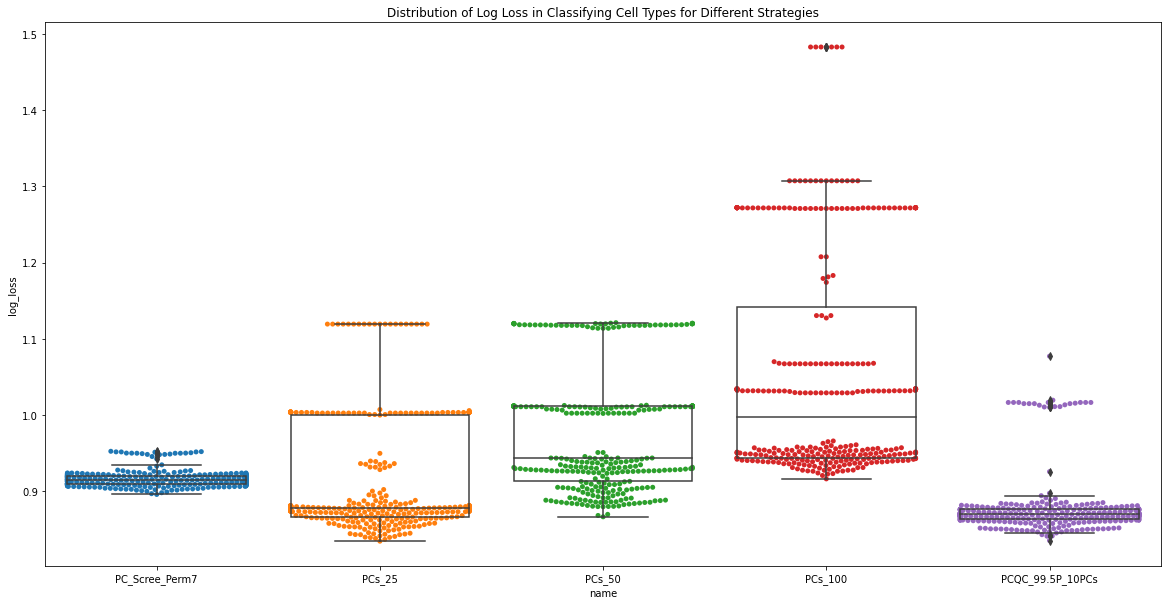

In [39]:
plt.rcParams['figure.figsize'] = [20, 10]
sns.boxplot('name', 'log_loss', data=df_stats, boxprops={'facecolor':'None'})
sns.swarmplot('name', 'log_loss', data=df_stats, zorder=.5)
plt.title('Distribution of Log Loss in Classifying Cell Types for Different Strategies')
plot_dictionary['LogLoss'] = plt.gca().get_figure()

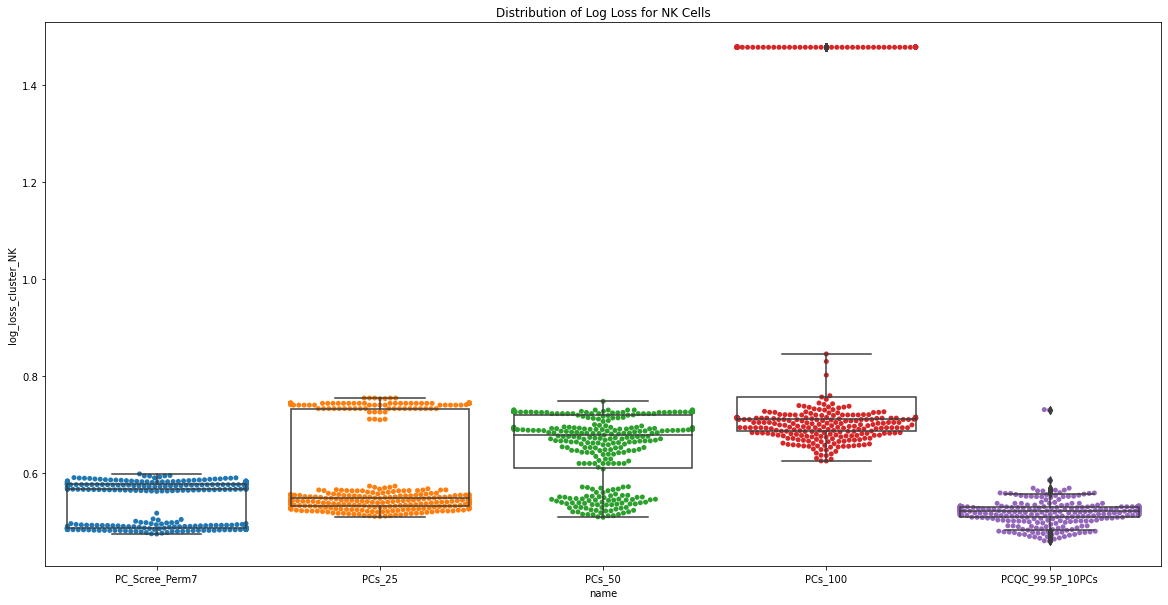

In [69]:
plt.rcParams['figure.figsize'] = [20, 10]
sns.boxplot('name', 'log_loss_cluster_NK', data=df_stats, boxprops={'facecolor':'None'})
sns.swarmplot('name', 'log_loss_cluster_NK', data=df_stats, zorder=.5)
plt.title('Distribution of Log Loss for NK Cells')
plot_dictionary['NKLoss'] = plt.gca().get_figure()

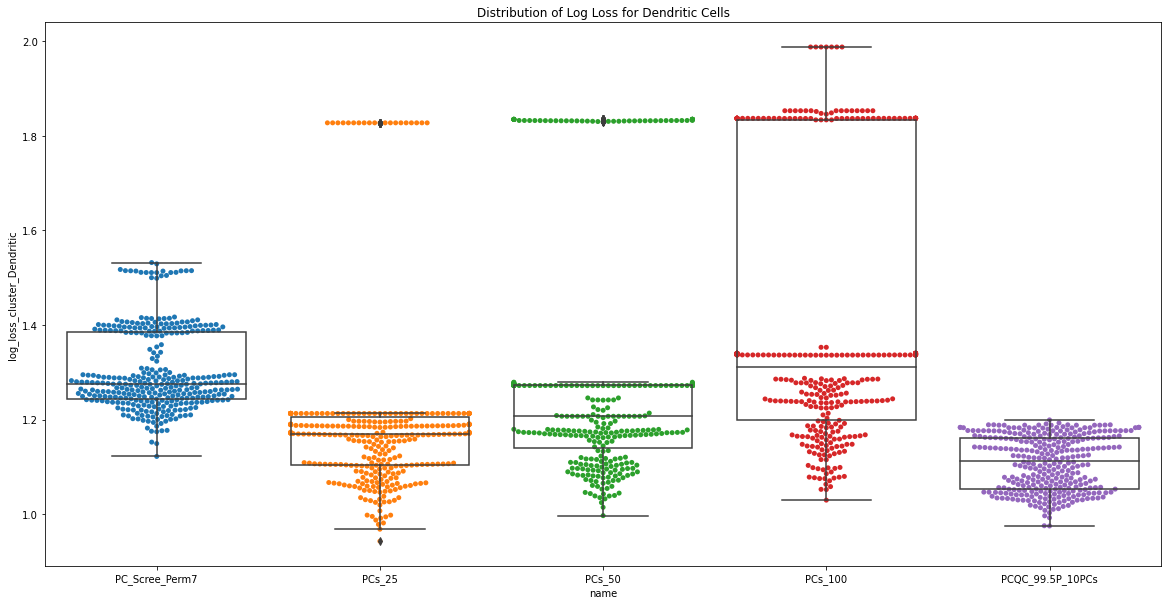

In [70]:
plt.rcParams['figure.figsize'] = [20, 10]
sns.boxplot('name', 'log_loss_cluster_Dendritic', data=df_stats, boxprops={'facecolor':'None'})
sns.swarmplot('name', 'log_loss_cluster_Dendritic', data=df_stats, zorder=.5)
plt.title('Distribution of Log Loss for Dendritic Cells')
plot_dictionary['DendriticLoss'] = plt.gca().get_figure()

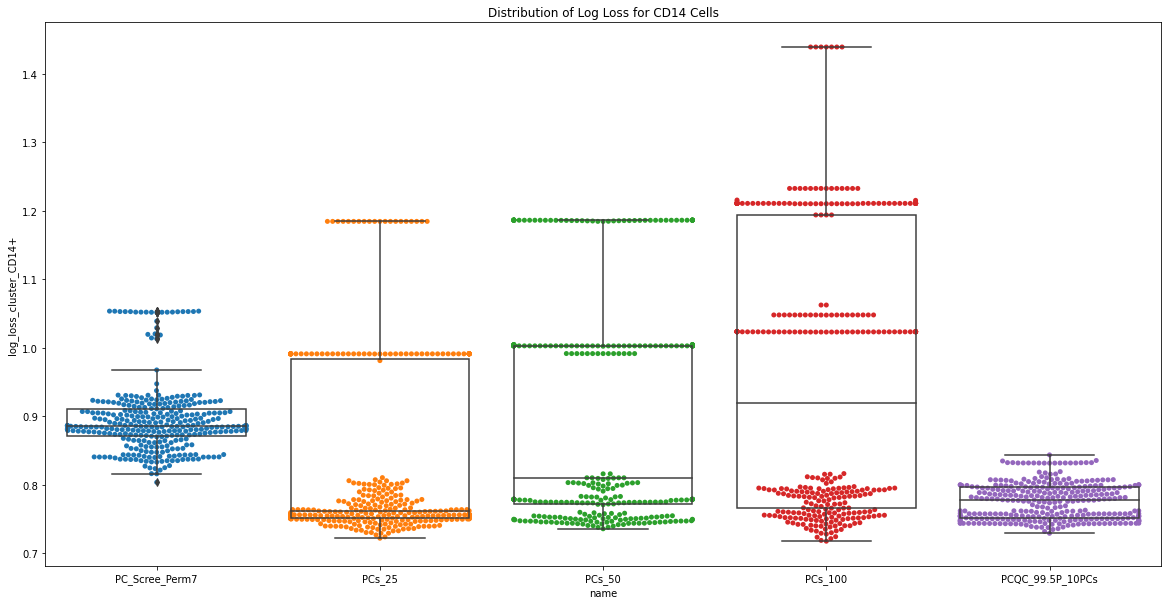

In [71]:
plt.rcParams['figure.figsize'] = [20, 10]
sns.boxplot('name', 'log_loss_cluster_CD14+', data=df_stats, boxprops={'facecolor':'None'})
sns.swarmplot('name', 'log_loss_cluster_CD14+', data=df_stats, zorder=.5)
plt.title('Distribution of Log Loss for CD14 Cells')
plot_dictionary['CD14+Loss'] = plt.gca().get_figure()

In [72]:
with PdfPages(output_plots) as pdf:
    for title in plot_dictionary.keys():
        pdf.savefig(plot_dictionary[title])

### End

In [50]:
pca = PC_Cluster(n_pcs = 100)
pca.fit(df.values)
pca.pc_distribution()
pca.pc_stats(thresholds=[0.9,0.95,0.98,0.99,0.995])
pca.select_top_pcs(criteria = 'evalue', n_top_pcs = 20)
reduced_matrix = pca.use_top_pcs()
cols = [0,1,2,3,4,5,6,10]
reduced_matrix = reduced_matrix[:,cols]

In [51]:
pca.select_top_pcs(criteria = 'evalue', n_top_pcs = 20)
reduced_matrix = pca.use_top_pcs()

In [55]:
adata_pcqc_kruskal = sc.AnnData(X = reduced_matrix)

In [57]:
df_stats = data_sim(adata_pcqc_kruskal, 'PCQC_Kruskal_8.15_Correctedv2', df_stats, ground_truth, 
                    random_state_start = 0, n_pcs = 0, use_rep = 'X')

In [60]:
pca.select_top_pcs(criteria = '100.0_Percentile', n_top_pcs = 13)
reduced_matrix = pca.use_top_pcs()
adata_pcqc_kruskal = sc.AnnData(X = reduced_matrix)
df_stats = data_sim(adata_pcqc_kruskal, 'PCQC_99.5P_13', df_stats, ground_truth, 
                    random_state_start = 0, n_pcs = 0, use_rep = 'X')

In [67]:
pca.select_top_pcs(criteria = '100.0_Percentile', n_top_pcs = 10)
reduced_matrix = pca.use_top_pcs()
adata_pcqc_kruskal = sc.AnnData(X = reduced_matrix)
df_stats = data_sim(adata_pcqc_kruskal, 'PCQC_99.5P_10', df_stats, ground_truth, 
                    random_state_start = 0, n_pcs = 0, use_rep = 'X')

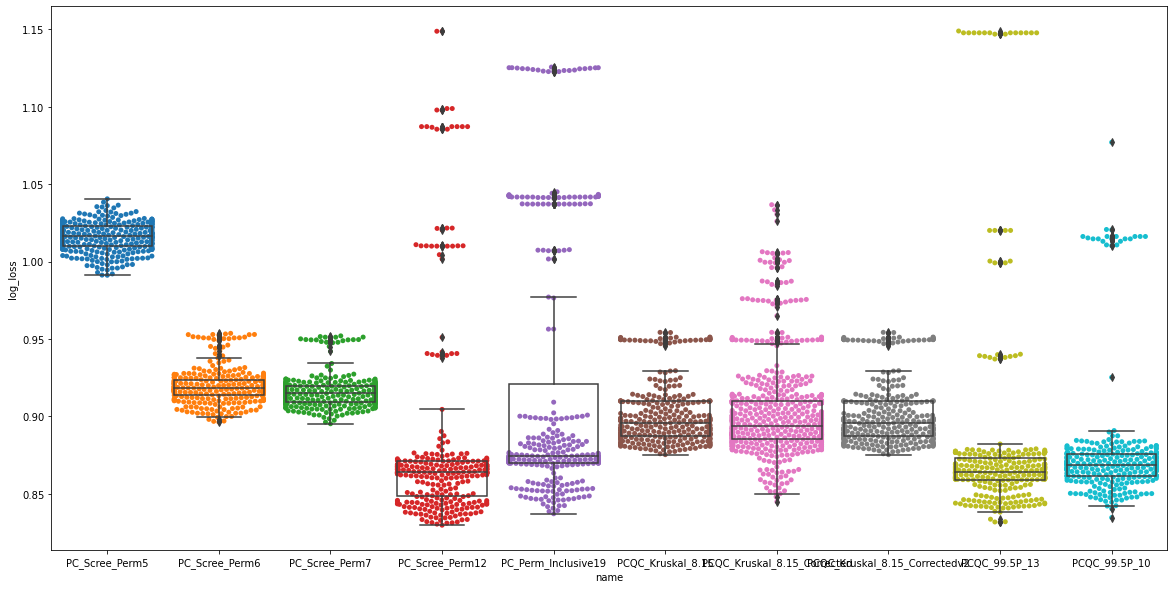

In [68]:
plt.rcParams['figure.figsize'] = [20, 10]
sns.boxplot('name', 'log_loss', data=df_stats, boxprops={'facecolor':'None'})
sns.swarmplot('name', 'log_loss', data=df_stats, zorder=.5)

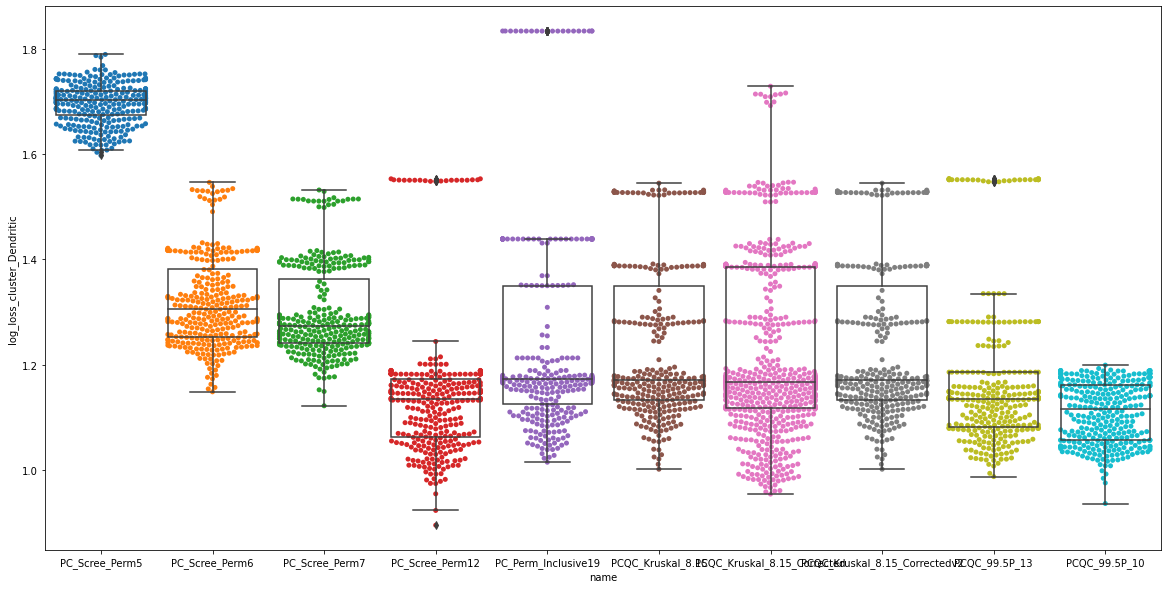

In [70]:
plt.rcParams['figure.figsize'] = [20, 10]
sns.boxplot('name', 'log_loss_cluster_Dendritic', data=df_stats, boxprops={'facecolor':'None'})
sns.swarmplot('name', 'log_loss_cluster_Dendritic', data=df_stats, zorder=.5)

In [69]:
df_stats.groupby('name').median()

,resolution,log_loss,aps,weighted_accuracy,log_loss_cluster_B Cells,log_loss_cluster_CD14+,log_loss_cluster_CD4 T,log_loss_cluster_CD8,log_loss_cluster_Dendritic,log_loss_cluster_FCGR3A Monocytes,log_loss_cluster_Megakaryocytes,log_loss_cluster_NK,log_loss_cluster_Other
name,,,,,,,,,,,,,
PCQC_99.5P_10,1.0,0.868732,0.606573,0.715615,0.566551,0.776807,1.343606,1.360643,1.115870,0.377687,0.294992,0.522200,1.490331
PCQC_99.5P_13,1.0,0.864130,0.604992,0.715579,0.574190,0.775493,1.322022,1.363706,1.135287,0.358073,0.289264,0.512963,1.474592
PCQC_Kruskal_8.15,1.0,0.895755,0.597757,0.701081,0.571432,0.822454,1.347936,1.387655,1.170251,0.363243,0.291100,0.561167,1.499791
PCQC_Kruskal_8.15_Corrected,0.8,0.893951,0.597839,0.701299,0.573642,0.822430,1.345636,1.397673,1.167866,0.366875,0.291671,0.566357,1.498493
PCQC_Kruskal_8.15_Correctedv2,1.0,0.895755,0.597757,0.701081,0.571432,0.822454,1.347936,1.387655,1.170251,0.363243,0.291100,0.561167,1.499791
PC_Perm_Inclusive19,1.0,0.874304,0.602230,0.713185,0.588100,0.775026,1.332104,1.352738,1.173066,0.403609,0.294220,0.516032,1.483991
PC_Scree_Perm12,1.0,0.864355,0.603936,0.716158,0.572678,0.774415,1.338012,1.359438,1.135205,0.362238,0.288375,0.514196,1.485059
PC_Scree_Perm5,1.0,1.016464,0.545620,0.626025,0.578060,0.935699,1.337049,1.444276,1.702155,0.855401,0.265658,0.524376,1.497769
PC_Scree_Perm6,1.0,0.918404,0.569170,0.688256,0.576706,0.886936,1.331593,1.472881,1.306552,0.396885,0.274010,0.530621,1.502782


In [44]:
df_stats.groupby(['name','resolution','n_neighbors']).median()[15:30]

log_loss       aps  \
name                resolution n_neighbors                       
PCQC_Kruskal_8.15   1.6        25           0.883566  0.606183   
PC_Perm_Inclusive19 0.4        10           1.037085  0.477293   
                               15           1.042429  0.476591   
                               20           1.041612  0.476874   
                               25           1.124387  0.432743   
                    0.8        10           0.898456  0.589898   
                               15           0.871279  0.602062   
                               20           0.870542  0.602806   
                               25           0.871767  0.598833   
                    1.2        10           0.873461  0.606377   
                               15           0.849064  0.605849   
                               20           0.872845  0.603142   
                               25           0.872368  0.603269   
                    1.6        10           0.886132  0.612880   
                               15           0.854299  0.612908   

                                            weighted_accuracy  \
name                resolution n_neighbors                      
PCQC_Kruskal_8.15   1.6        25                    0.705204   
PC_Perm_Inclusive19 0.4        10                    0.574638   
                               15                    0.573349   
                               20                    0.573672   
                               25                    0.519557   
                    0.8        10                    0.701416   
                               15                    0.713229   
                               20                    0.713208   
                               25                    0.713763   
                    1.2        10                    0.714074   
                               15                    0.720871   
                               20                    0.713412   
                               25                    0.713947   
                    1.6        10                    0.713281   
                               15                    0.722658   

                                            log_loss_cluster_B Cells  \
name                resolution n_neighbors                             
PCQC_Kruskal_8.15   1.6        25                           0.548469   
PC_Perm_Inclusive19 0.4        10                           0.620308   
                               15                           0.619964   
                               20                           0.620383   
                               25                           0.626330   
                    0.8        10                           0.589837   
                               15                           0.588778   
                               20                           0.588720   
                               25                           0.589180   
                    1.2        10                           0.578784   
                               15                           0.584657   
                               20                           0.586090   
                               25                           0.585878   
                    1.6        10                           0.558571   
                               15                           0.565353   

                                            log_loss_cluster_CD14+  \
name                resolution n_neighbors                           
PCQC_Kruskal_8.15   1.6        25                         0.807203   
PC_Perm_Inclusive19 0.4        10                         1.035313   
                               15                         1.035085   
                               20                         1.035363   
                               25                         1.184131   
                    0.8        10                         0.822832   
                              